# Caso 3: Selección y Programación de Proyectos I

---
## Maestría en Inteligencia Analítica de Datos


## Instrucciones generales

El primer paso antes de resolver este laboratorio es leer y entender el **enunciado del caso**. Una vez tengas claro el caso, te explicamos la estructura de este laboratorio (los demás laboratorios siguen una estructura similar). 

Este laboratorio tiene las siguientes secciones: 
* **Formulación**: un breve resumen del modelo con notación matemática y descripción de sus componentes
* **Importación de librerías**
* **Creación de parámetros**
* **Modelado**: aquí implementamos el modelo visto en la formulación (aquí encontrarás por lo general celdas de código que debes completar, ¡nosotros te guiaremos en el proceso!)
* **Reporte de Resultados**: esta sección nos muestra las soluciones encontradas por el modelo y, en ocasiones, algunas visualizaciones interesantes para entenderlo mejor. (es posible que en ciertas prácticas debas completar algunas celdas también)

Este tipo de actividades se evaluará sobre un total de 100 puntos. Las celdas calificables se distinguen por tener la instrucción `# your code here`. Antes de estas celdas  encontrarás instrucciones y consejos para resolver las preguntas, también el puntaje que le corresponde. **Ten en cuenta que si no sigues las instrucciones al pie de la letra, no obtendrás el puntaje. Por ejemplo, debes llamar a las variables en Python y nombrar los elementos de tu modelo exactamente cómo lo indica el enunciado. De lo contrario, no obtendrás puntaje en ese inciso.** 

¡Éxitos!

## Formulación
---

Te presentamos la formulación del caso de la semana de forma resumida. Te recomendamos revisar la formulación una vez hayas leído el enunciado del caso. Es bueno que te familiarices con los elementos de la formulación antes de iniciar la implementación.

### Conjuntos y Parámetros
>#### **Conjuntos**
>* $P$: conjunto de pozos candidatos
>* $T$: conjunto de periodos (años) en el horizonte de planeación

>#### **Parámetros**
>* $n$: máximo número de pozos a perforar en el horizonte de planeación
>* $b$: presupuesto total de la compañía para la realización de proyectos (en millones de USD)
>* $s$: número de operarios disponibles por año
>* $u$: número de generadores disponibles por año
>* $p_i$: promedio diario (miles de barriles) de crudo producidos en el pozo $i\in P$
>* $o_i$: operarios requeridos para perforar el pozo $i\in P$
>* $g_i$: generadores requeridos para perforar el pozo $i\in P$
>* $m_t$: meta de producción (miles de barriles) promedio diaria para el año $t\in T$
>* $v_{it}$: utilidad esperada por perforar el pozo $i\in P$ en el año $t\in T$ (en millones de USD)
>* $c_{it}$: costo por perforar el pozo $i\in P$ en el año $t\in T$ (en millones de USD)


### Variables de Decisión
> $x_{it} = \begin{cases}1, & \text{si el pozo} \, i\in P \text{ se perfora en el año} \, t\in T \\ 0, & \text{de lo contrario}\end{cases}$


### Restricciones
> 1. Un pozo se perfora máximo una vez en el horizonte de planeación
>> $\sum_{t\in T}x_{it} \, \leq \, 1, \; \forall i\in P$
> 2. La inversión total no puede superar el presupuesto
>>$\sum_{i\in P}\sum_{t\in T}c_{it}x_{it} \, \leq \, b$
> 3. Las metas de producción (en miles de barriles diarios) deben ser cumplidas
>>$\sum_{i\in P}p_i x_{it} \, \geq \, m_t \; \forall t\in T$
> 4. No se debe exceder la cantidad de operarios disponibles
>>$\sum_{i\in P}o_i x_{it} \, \leq \, s \; \forall t\in T$
> 5. No se debe exceder la cantidad de generadores disponibles
>>$\sum_{i\in P}g_i x_{it} \, \leq \, u \; \forall t\in T$
> 6. No se debe exceder la cantidad de pozos perforados impuesta por el gobierno
>>$\sum_{i\in P}\sum_{t\in T}x_{it} \, \leq \, n$

>
> **Naturaleza de las variables**
>> $x_{it} \in \{0,1\}, \; \forall i\in P, t\in T$

### Función Objetivo
> Maximizar la utilidad total
>> $ \max \; \sum_{i\in P}\sum_{t\in T} v_{it}x_{it}$

## Importación de librerías
---

Antes de empezar, es necesario importar los paquetes que vamos a utilizar durante la práctica.
El paquete `pulp` permite crear modelos de optimización, crear variables, añadir restricciones y muchos más. Le asignamos el alias de `lp`.
El paquete `pandas` es muy útil para el análisis de datos en general. Le asignamos el alias de `pd`.
A lo largo del código, puedes corroborar que se usan estos paquetes cuando veas un objeto o método que empiece con los alias `lp.` o `pd.`

In [43]:
import pulp as lp  
import pandas as pd

In [44]:
!pip show pulp

Name: PuLP
Version: 3.1.1
Summary: PuLP is an LP modeler written in python. PuLP can generate MPS or LP files and call GLPK, COIN CLP/CBC, CPLEX, and GUROBI to solve linear problems.
Home-page: 
Author: J.S. Roy
Author-email: "S.A. Mitchell" <pulp@stuartmitchell.com>, Franco Peschiera <pchtsp@gmail.com>
License: MIT
Location: C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: 
Required-by: 


## Creación de Parámetros
---

### Conjuntos

Para empezar, es necesario crear los conjuntos que vimos en la formulación. Esto nos permite indexar variables, crear sumatorias, múltiples restricciones y demás. 

En Python, los conjuntos son sencillamente listas (`list`) que contienen los elementos de cada conjunto, como en el caso de los pozos `Pozos`. En ocasiones, cuando el conjunto contiene números ordenados (como el conjunto de años `Tiempos`), utilizamos la función `range(desde, hasta)` que crea una secuencia de números rápidamente. 

También es posible que alguna variable o parámetro tengan múltiples índices. Para estos casos, creamos una lista de tuplas (e.g., `(i,t)`) que contengan todas las posibles combinaciones de índices de los dos conjuntos. La lista `Pozo_x_Tiempo` tiene esta característica.

In [45]:
# Conjunto de pozos
Pozos = [
    "DELE B-1",
    "EL MORRO-1",
    "FLORENA A-5",
    "FLORENA C-6",
    "FLORENA N-2",
    "FLORENA N-4 ST",
    "FLORENA-T8",
    "PAUTO J-6",
    "PAUTO M4",
    "PAUTO M-5",
    "PAUTO SUR B-1",
    "PAUTO SUR C-2",
    "PAUTO-1",
    "VOLCANERA A-1",
    "VOLCANERA C-2",
]

# Conjunto de años
Tiempos = range(1, 11)

# Conjunto de tuplas (pozo, año)
Pozo_x_Tiempo = [(i, t) for i in Pozos for t in Tiempos]


In [46]:
print(Pozo_x_Tiempo)

[('DELE B-1', 1), ('DELE B-1', 2), ('DELE B-1', 3), ('DELE B-1', 4), ('DELE B-1', 5), ('DELE B-1', 6), ('DELE B-1', 7), ('DELE B-1', 8), ('DELE B-1', 9), ('DELE B-1', 10), ('EL MORRO-1', 1), ('EL MORRO-1', 2), ('EL MORRO-1', 3), ('EL MORRO-1', 4), ('EL MORRO-1', 5), ('EL MORRO-1', 6), ('EL MORRO-1', 7), ('EL MORRO-1', 8), ('EL MORRO-1', 9), ('EL MORRO-1', 10), ('FLORENA A-5', 1), ('FLORENA A-5', 2), ('FLORENA A-5', 3), ('FLORENA A-5', 4), ('FLORENA A-5', 5), ('FLORENA A-5', 6), ('FLORENA A-5', 7), ('FLORENA A-5', 8), ('FLORENA A-5', 9), ('FLORENA A-5', 10), ('FLORENA C-6', 1), ('FLORENA C-6', 2), ('FLORENA C-6', 3), ('FLORENA C-6', 4), ('FLORENA C-6', 5), ('FLORENA C-6', 6), ('FLORENA C-6', 7), ('FLORENA C-6', 8), ('FLORENA C-6', 9), ('FLORENA C-6', 10), ('FLORENA N-2', 1), ('FLORENA N-2', 2), ('FLORENA N-2', 3), ('FLORENA N-2', 4), ('FLORENA N-2', 5), ('FLORENA N-2', 6), ('FLORENA N-2', 7), ('FLORENA N-2', 8), ('FLORENA N-2', 9), ('FLORENA N-2', 10), ('FLORENA N-4 ST', 1), ('FLORENA N

### Parámetros

Ahora bien, ya que se tienen los conjuntos, debemos crear los parámetros del problema. En ocasiones, algunos parámetros estarán guardados en archivos de soporte (`.csv`, `.xlsx`, etc.), pero en nuestro caso los vamos a crear manualmente para comprender el proceso de creación. 

Los parámetros deben ser numéricos (`int` o `float`). Si el parámetro no esta indexado en ningún conjunto, como `presupuesto`, simplemente se asigna el valor al objeto de Python. Por otro lado, si está indexado en algún conjunto, es necesario crear un diccionario `dict` con los índices en las **llaves** y los números en los **valores** del diccionario (ver `metas`). Para ser más eficientes, podemos crear un solo diccionario para varios parámetros que compartan los mismos índices, para esto, se colocan los índices en las **llaves** y los parámetros como una lista en cada uno de los **valores** (ver `dataPozos`). Sin embargo, es necesario separar este diccionario al final usando la función `lp.splitDict()` para usar cada parámetro de forma independiente.

In [47]:
# Presupuesto máximo
presupuesto = 100 
# Máximo número de proyectos a realizar - restricción ambiental
maxProyectos = 12  
# Número de operarios por año
maxOperarios = 4   
# Número de generadores por año
maxGeneradores = 4 

# Parámetros indexados en años
# tiempo: meta (miles de barriles por día)
metas = {1: 3, 2: 4, 3: 5, 4: 4, 5: 5, 6: 3, 7: 5, 8: 4, 9: 4, 10: 6}

# Parámetros indexados en los pozos (abajo se separan en diccionarios diferentes)
# pozo: prod.minima, prod.moda, prod.máxima, operarios, generadores
dataPozos = {
             'DELE B-1':       [1,3,4,3,3],
             'EL MORRO-1':     [3,4,6,2,3],
             'FLORENA A-5':    [3,6,7,4,2],
             'FLORENA C-6':    [1,3,6,4,3],
             'FLORENA N-2':    [4,6,10,3,2],
             'FLORENA N-4 ST': [1,4,6,4,3],
             'FLORENA-T8':     [2,4,8,2,2],
             'PAUTO J-6':      [2,3,5,3,2],
             'PAUTO M4':       [3,5,7,3,3],
             'PAUTO M-5':      [1,4,8,4,2],
             'PAUTO SUR B-1':  [4,5,7,2,4],
             'PAUTO SUR C-2':  [4,6,8,3,3],
             'PAUTO-1':        [3,5,8,3,2],
             'VOLCANERA A-1':  [4,5,9,2,3],
             'VOLCANERA C-2':  [2,5,7,2,2]
}

# Parámetros indexados en los pozos y los años (abajo se separan en diccionarios diferentes)
# (pozo, año):   costo, utilidad  
dataPozoAño ={ 
                ('DELE B-1',1)       :[13,14],
                ('EL MORRO-1',1)     :[21,81],
                ('FLORENA A-5',1)    :[8,81],
                ('FLORENA C-6',1)    :[7,93],
                ('FLORENA N-2',1)    :[3,26],
                ('FLORENA N-4 ST',1) :[23,77],
                ('FLORENA-T8',1)     :[6,88],
                ('PAUTO J-6',1)      :[2,13],
                ('PAUTO M4',1)       :[9,57],
                ('PAUTO M-5',1)      :[12,34],
                ('PAUTO SUR B-1',1)  :[2,10],
                ('PAUTO SUR C-2',1)  :[21,20],
                ('PAUTO-1',1)        :[12,43],
                ('VOLCANERA A-1',1)  :[16,51],
                ('VOLCANERA C-2',1)  :[22,44],
                ('DELE B-1',2)       :[25,55],
                ('EL MORRO-1',2)     :[9,54],
                ('FLORENA A-5',2)    :[15,70],
                ('FLORENA C-6',2)    :[14,40],
                ('FLORENA N-2',2)    :[23,65],
                ('FLORENA N-4 ST',2) :[5,55],
                ('FLORENA-T8',2)     :[10,24],
                ('PAUTO J-6',2)      :[23,92],
                ('PAUTO M4',2)       :[10,58],
                ('PAUTO M-5',2)      :[3,26],
                ('PAUTO SUR B-1',2)  :[16,72],
                ('PAUTO SUR C-2',2)  :[11,39],
                ('PAUTO-1',2)        :[2,57],
                ('VOLCANERA A-1',2)  :[15,51],
                ('VOLCANERA C-2',2)  :[8,45],
                ('DELE B-1',3)       :[17,74],
                ('EL MORRO-1',3)     :[22,23],
                ('FLORENA A-5',3)    :[12,44],
                ('FLORENA C-6',3)    :[11,31],
                ('FLORENA N-2',3)    :[7,53],
                ('FLORENA N-4 ST',3) :[12,71],
                ('FLORENA-T8',3)     :[12,80],
                ('PAUTO J-6',3)      :[17,22],
                ('PAUTO M4',3)       :[14,59],
                ('PAUTO M-5',3)      :[15,34],
                ('PAUTO SUR B-1',3)  :[24,88],
                ('PAUTO SUR C-2',3)  :[25,61],
                ('PAUTO-1',3)        :[8,46],
                ('VOLCANERA A-1',3)  :[14,33],
                ('VOLCANERA C-2',3)  :[17,15],
                ('DELE B-1',4)       :[19,75],
                ('EL MORRO-1',4)     :[6,70],
                ('FLORENA A-5',4)    :[23,18],
                ('FLORENA C-6',4)    :[16,36],
                ('FLORENA N-2',4)    :[14,44],
                ('FLORENA N-4 ST',4) :[18,34],
                ('FLORENA-T8',4)     :[6,22],
                ('PAUTO J-6',4)      :[20,30],
                ('PAUTO M4',4)       :[5,93],
                ('PAUTO M-5',4)      :[7,68],
                ('PAUTO SUR B-1',4)  :[25,12],
                ('PAUTO SUR C-2',4)  :[13,75],
                ('PAUTO-1',4)        :[12,56],
                ('VOLCANERA A-1',4)  :[10,16],
                ('VOLCANERA C-2',4)  :[6,11],
                ('DELE B-1',5)       :[7,54],
                ('EL MORRO-1',5)     :[8,58],
                ('FLORENA A-5',5)    :[22,15],
                ('FLORENA C-6',5)    :[17,29],
                ('FLORENA N-2',5)    :[20,95],
                ('FLORENA N-4 ST',5) :[17,32],
                ('FLORENA-T8',5)     :[10,91],
                ('PAUTO J-6',5)      :[6,29],
                ('PAUTO M4',5)       :[6,72],
                ('PAUTO M-5',5)      :[25,91],
                ('PAUTO SUR B-1',5)  :[21,95],
                ('PAUTO SUR C-2',5)  :[15,63],
                ('PAUTO-1',5)        :[17,64],
                ('VOLCANERA A-1',5)  :[12,54],
                ('VOLCANERA C-2',5)  :[17,19],
                ('DELE B-1',6)       :[10,84],
                ('EL MORRO-1',6)     :[13,48],
                ('FLORENA A-5',6)    :[9,10],
                ('FLORENA C-6',6)    :[25,32],
                ('FLORENA N-2',6)    :[17,92],
                ('FLORENA N-4 ST',6) :[25,21],
                ('FLORENA-T8',6)     :[5,62],
                ('PAUTO J-6',6)      :[23,28],
                ('PAUTO M4',6)       :[22,87],
                ('PAUTO M-5',6)      :[7,97],
                ('PAUTO SUR B-1',6)  :[25,88],
                ('PAUTO SUR C-2',6)  :[19,88],
                ('PAUTO-1',6)        :[4,66],
                ('VOLCANERA A-1',6)  :[6,32],
                ('VOLCANERA C-2',6)  :[5,2],
                ('DELE B-1',7)       :[12,94],
                ('EL MORRO-1',7)     :[3,45],
                ('FLORENA A-5',7)    :[19,15],
                ('FLORENA C-6',7)    :[4,40],
                ('FLORENA N-2',7)    :[6,103],
                ('FLORENA N-4 ST',7) :[21,9],
                ('FLORENA-T8',7)     :[13,63],
                ('PAUTO J-6',7)      :[8,25],
                ('PAUTO M4',7)       :[15,94],
                ('PAUTO M-5',7)      :[8,113],
                ('PAUTO SUR B-1',7)  :[10,99],
                ('PAUTO SUR C-2',7)  :[12,100],
                ('PAUTO-1',7)        :[3,70],
                ('VOLCANERA A-1',7)  :[12,29],
                ('VOLCANERA C-2',7)  :[7,13],
                ('DELE B-1',8)       :[23,104],
                ('EL MORRO-1',8)     :[13,42],
                ('FLORENA A-5',8)    :[16,21],
                ('FLORENA C-6',8)    :[7,48],
                ('FLORENA N-2',8)    :[4,94],
                ('FLORENA N-4 ST',8) :[11,5],
                ('FLORENA-T8',8)     :[20,63],
                ('PAUTO J-6',8)      :[15,22],
                ('PAUTO M4',8)       :[22,100],
                ('PAUTO M-5',8)      :[21,129],
                ('PAUTO SUR B-1',8)  :[19,110],
                ('PAUTO SUR C-2',8)  :[14,113],
                ('PAUTO-1',8)        :[15,74],
                ('VOLCANERA A-1',8)  :[8,27],
                ('VOLCANERA C-2',8)  :[19,20],
                ('DELE B-1',9)       :[8,114],
                ('EL MORRO-1',9)     :[23,39],
                ('FLORENA A-5',9)    :[2,25],
                ('FLORENA C-6',9)    :[23,56],
                ('FLORENA N-2',9)    :[23,87],
                ('FLORENA N-4 ST',9) :[20,10],
                ('FLORENA-T8',9)     :[11,63],
                ('PAUTO J-6',9)      :[20,19],
                ('PAUTO M4',9)       :[8,107],
                ('PAUTO M-5',9)      :[15,144],
                ('PAUTO SUR B-1',9)  :[12,121],
                ('PAUTO SUR C-2',9)  :[6,120],
                ('PAUTO-1',9)        :[2,78],
                ('VOLCANERA A-1',9)  :[5,33],
                ('VOLCANERA C-2',9)  :[25,24],
                ('DELE B-1',10)       :[14,124],
                ('EL MORRO-1',10)     :[19,36],
                ('FLORENA A-5',10)    :[22,32],
                ('FLORENA C-6',10)    :[13,50],
                ('FLORENA N-2',10)    :[20,80],
                ('FLORENA N-4 ST',10) :[16,8],
                ('FLORENA-T8',10)     :[9,64],
                ('PAUTO J-6',10)      :[7,16],
                ('PAUTO M4',10)       :[15,113],
                ('PAUTO M-5',10)      :[10,160],
                ('PAUTO SUR B-1',10)  :[5,132],
                ('PAUTO SUR C-2',10)  :[2,115],
                ('PAUTO-1',10)        :[16,82],
                ('VOLCANERA A-1',10)  :[25,40],
                ('VOLCANERA C-2',10)  :[18,32]
}

# Separando datos en diccionarios independientes que comparten las misma llaves
(prodMin, prodModa, prodMax, operarios, generadores) = lp.splitDict(dataPozos)
(costo, utilidad) = lp.splitDict(dataPozoAño)

In [48]:
prodModa[Pozos[0]]

3

**Celda de Prueba (0 puntos)**

Es una buena práctica imprimir algunos objetos que contienen los parámetros en la consola luego de crearlos. De esta forma puedes corregir errores y conocer con las estructuras de datos que se van a utilizar. Por ejemplo, si sabes que `operarios` es un diccionario (`dict`), podrás usar el comando `operarios[<llave>]` para pedir un valor en particular. Puedes hacer estas pruebas en la celda a continuación.

* **Esta celda no es calificable**

## Modelado
---

### Declaración del modelo

El primer paso para crear un modelo de optimización en `pulp`, es crear un objeto que contenga el objeto modelo. A este objeto luego podremos agregarle variables, restricciones, pedirle que use algún algoritmo de optimización, etc. A continuación, encontrarás instrucciones para crear este objeto.

**Pregunta 1 (10 puntos)**
* Crea un objeto modelo en PuLP (`lp.LpProblem`) llamado `problema`
* Indica el sentido de la optimización: maximizar o minimizar

> **Recuerda** que el sentido se indica con el argumento `sense` en `lp.LpProblem()`, que toma valores `lp.LpMaximize` o `lp.LpMinimize`

In [49]:
# your code here
problema = lp.LpProblem(sense=lp.LpMaximize) 


### Variables de Decisión

Ahora que tienes el objeto modelo (`problema`) listo, deberás crear las variables que poblarán el modelo y te permitiran crear la función objetivo y restricciones. En este caso, sólo tenemos un grupo de variables $x_{it}$ que comparten características como la naturaleza de las variables y que sus índices pertenecen a los mismos conjuntos. A continuación, puedes comprobar la formulación de las variables y en la siguiente celda encontrarás instrucciones para crear las variables del problema.

>* $x_{it} = \begin{cases}1, & \text{si el pozo} \, i\in P \text{ se perfora en el año} \, t\in T \\ 0, & \text{de lo contrario}\end{cases} $

**Pregunta 2 (10 puntos)**
* Crea las variables del modelo: `x`, usando el método `lp.LpVariable.dicts()`. En caso de ser necesario, el enlace de la explicación del método se encuentra en el siguiente enlace: pulp: Pulp classes — https://www.coin-or.org/PuLP/pulp.html#pulp.LpVariable
* Especifica el nombre de las variables como `perforar` con el argumento `name`.
* Especifica el conjunto sobre el cual está indexado la variable con el argumento `indexs`. **Ayuda:** puede ser útil la lista `Pozo_x_Tiempo`. 
* Especifica el tipo de variable con el argumento `cat` (continua: `lp.LpContinuous`, entera: `lp.LpInteger` o binaria: `lp.LpBinary`)

In [50]:
# your code here
x = lp.LpVariable.dicts(name ='perforar', indices = Pozo_x_Tiempo, cat=lp.LpBinary)

### Función Objetivo

¡Ya tienes listo el modelo y las variables de decisión! Ahora es momento de crear la función objetivo del problema. En la siguiente celda encontrarás instrucciones para incluirla en el modelo haciendo uso de las variables que creaste anteriormente.

Maximizar la utilidad total
> $\max \; \sum_{i\in P} \sum_{t\in T} v_{it}x_{it}$

**Pregunta 3 (10 puntos)**
* Crea la función objetivo y agrégala al modelo `problema`

> **Recuerda** que para agregar una función objetivo o restricción a un modelo en pulp se usa la sintaxis: `<modelo> += <expresion>`

> **Recuerda** que una función objetivo en `pulp` consiste en multiplicar variables de tipo `lp.pulp.Variable` (como `x[i,t]`) por constantes así: `<variable>*<int|float>` y luego sumarlas o restarlas así: `<var1>*<const1> + <var2>*<const2>+...`.

> **Recuerda** que, para evitar escribir una sumatoria de muchos términos uno a uno, `pulp` permite crear sumatorias que recorran conjuntos siempre y cuando las variables esten indexadas (como `x`). Para esto, utiliza `lp.lpSum(<expresion> for <indices> in <conjunto>)`.

> **Ejemplo**:
>> $ \sum_{i \in I}c_i x_i$
es equivalente a `lp.lpSum(c[i]*x[i] for i in I)`

In [53]:
# Funcion objetivo
problema += lp.lpSum([dataPozoAño[i, t][1] * x[i, t] for (i, t) in Pozo_x_Tiempo])

### Restricciones

Llegó la hora de crear las restricciones del modelo. De nuevo, se utilizará el objeto `problema` y las variables creadas anteriormente. Además, será necesario utilizar algunos de los parámetros creados al principio. Vamos a crear las restricciones en el orden en que se formularon. Abajo encontrarás algunos consejos que aplican para todas las restricciones. Antes de cada restricción se incluyen algunas instrucciones más detalladas.

**Consejos para preguntas 4 a 9**

> **Recuerda** que para crear restricciones se debe usar la sintaxis: `<modelo> += <expresion_lado_izq> ==|>=|<= <expresion_lado_der>, 'Nombre_de_la_restriccion'`

> **Recuerda** que las expresiones son combinaciones lineales de las variables, como: `<var1>*<const1> + <var2>*<const2>`

> **Recuerda** que puedes usar `lp.lpSum()` para crear sumatorias (ver **Pregunta 3**)

> **Recuerda** que para crear múltiples restricciones usando $\forall i \in I$, se debe utilizar la sintaxis:
>>    * `for i in I:` 
>>       * `<restriccion>`

> **Ejemplo**
>> La siguiente restricción: $\sum_{i \in I} a_{ij} x_{ij} \geq 1, \; \forall j \in J$ es equivalente a:
>> ```python
for j in J:
    <modelo> += lp.lpSum(a[i,j] * x[i,j] for i in I) >= 1, 'R1_'+str(j)
```
> **Advertencia**: `pulp` no permite sobreescribir restricciones, entonces, si ya creaste una restricción y quieres crearla de nuevo para corregir algo, asegúrate de volver a crear el modelo `problema` desde el principio (nosotros haremos esto antes de calificar, no te preocupes).

**Pregunta 4 (10 puntos)**
* Crea el siguiente grupo de restricciones, asígnale el nombre `'R1_'+str(<indice_del_para_todo>)` y añádelo al modelo:
> 1. Un pozo se perfora máximo una vez en el horizonte de planeación
>> $\sum_{t\in T}x_{it} \, \leq \, 1, \; \forall i\in P$

In [54]:
# your code here
for i in Pozos:
    problema += lp.lpSum([x[i, t] for t in Tiempos]) <= 1, 'R1_'+str(i)

**Pregunta 5 (10 puntos)**
* Crea la siguiente restricción, asígnale el nombre `'R2'` y añádela al modelo:
> 2. La inversión total no puede superar el presupuesto
>>$\sum_{i\in P}\sum_{t\in T} c_{it}x_{it} \, \leq \, b$

In [56]:
# your code here
problema += lp.lpSum([dataPozoAño[i, t][0] * x[i, t] for (i, t) in Pozo_x_Tiempo]) <= presupuesto, 'R2'

**Pregunta 6 (10 puntos)**
* Crea el siguiente grupo de restricciones, asígnale el nombre `'R3_'+str(<indice_del_para_todo>)` y añádelo al modelo:
> 3. Las metas de producción (en miles de barriles diarios) deben ser cumplidas
>>$\sum_{i\in P}p_i x_{it} \, \geq \, m_t \; \forall t\in T$

> **Recuerda** que el parámetro $p_i$ es el promedio diario (miles de barriles) de crudo producidos en el pozo $i\in P$. Por esta razón, en la restricción tendrás que usar los parámetros `prodMin`, `prodModa`, y `prodMax` para calcular este promedio. Revisa el vídeo 'Formulación del caso'.   

In [57]:
# your code here
for t in Tiempos:
    problema += lp.lpSum([((prodMin[i] + prodMax[i] + prodModa[i]) / 3) * x[i, t] for i in Pozos]) >= metas[t], 'R3_'+str(t)

**Pregunta 7 (10 puntos)**
* Crea el siguiente grupo de restricciones, asígnale el nombre `'R4_'+str(<indice_del_para_todo>)` y añádelo al modelo:
> 4. No se debe exceder la cantidad de operarios disponibles
>>$\sum_{i\in P}o_i x_{it} \, \leq \, s \; \forall t\in T$

In [58]:
# your code here
for t in Tiempos:
    problema += lp.lpSum([operarios[i] * x[i, t] for i in Pozos]) <= maxOperarios, 'R4_'+str(t)

**Pregunta 8 (10 puntos)**
* Crea el siguiente grupo de restricciones, asígnale el nombre `'R5_'+str(<indice_del_para_todo>)` y añádelo al modelo:
> 5. No se debe exceder la cantidad de generadores disponibles
>>$\sum_{i\in P}g_i x_{it} \, \leq \, u \; \forall t\in T$

In [59]:
# your code here
for t in Tiempos:
    problema += lp.lpSum([generadores[i] * x[i, t] for i in Pozos]) <= maxGeneradores, 'R5_'+str(t)

**Pregunta 9 (10 puntos)**
* Crea la siguiente restricción, asígnale el nombre `'R6'` y añádela al modelo:
> 6. No se debe exceder la cantidad de pozos perforados impuesta por el gobierno
>>$\sum_{i\in P}\sum_{t\in T}x_{it} \, \leq \, n$

In [60]:
# your code here
problema += lp.lpSum([x[i, t] for (i, t) in Pozo_x_Tiempo]) <= maxProyectos, 'R6'

### Invocar el optimizador

Ahora que el modelo esta listo, viene la mejor parte: ¡Correr el modelo!. La celda a continuación se encarga de llamar al optimizador de `pulp` y guardar las soluciones del modelo (si llega a optimalidad) en los objetos modelo y variables. Más adelante miraremos cómo extraer la solución y otras métricas de interés.

In [61]:
problema.solve()

1

## Reporte de resultados
---

### Estado del optimizador y función objetivo

Después de correr el modelo, es muy común consultar el estado del optimizador y el valor de la función objetivo. A continuación, te compartimos las intrucciones para que lo puedas hacer tú mismo.

**Pregunta 10 (5 puntos)**
* Despues de haber corrido el modelo: `<modelo>.solve()`, asigna a una nueva variable el estado del optimizador **en palabras** según `lp.LpStatus`. Esta nueva variable debe tener el nombre `estado`.

> **Recuerda** que al finalizar de correr el modelo, `<modelo>.status` tomará un valor de 1, -1, -2 o -3, que hace referencia a algún estado del optimizador:
*  0 $\rightarrow$ Sin Resolver: No se ha usado `<modelo>.solve()`
*  1 $\rightarrow$ Óptimo
* -1 $\rightarrow$ Infactible
* -2 $\rightarrow$ No acotado 
* -3 $\rightarrow$ Otros

> **Recuerda** que `lp.LpStatus` es un diccionario en PuLP que tiene como llaves los `status` del optimizador (número) y en los valores contiene el estados del optimizador correspondientes en palabras.

> **Recuerda** que puedes inspeccionar el contenido de `lp.LpStatus` corriendolo en una celda

In [62]:
estado = lp.LpStatus[problema.status]
print(f"Estado: {estado}")

Estado: Optimal


In [ ]:
# Esta celda esta reservada para uso del equipo docente

**Pregunta 11 (5 puntos)**

* Asigna el valor de la función objetivo a la variable `obj`

> **Recuerda** que `<modelo>.objective` contiene la **expresión** de la función objetivo, sin embargo, para conocer el **valor** de la función objetivo se debe reemplazar los valores de las variables en la solución dentro de esta expresión. Por fortuna, PuLP tiene una función que hace justo eso: `lp.value(<expresion>)`.


In [63]:
# your code here
obj = problema.objective.value()
print(f"Valor de la función objetivo: {obj}")

Valor de la función objetivo: 918.0


### Valores de las variables

También nos interesa conocer el valor de las variables en la solución. Fíjate cómo usamos el método `.value()` sobre la variable `x[i,t]` para conocer su valor en la solución. El resto del código se encarga de mostrar estos valores binarios de forma organizada usando un `DataFrame` de la librería `pandas`.

#### Pozos a perforar en cada año

In [64]:
matriz = []
for i in Pozos:
    fila = []  # Cada fila contiene la información de un pozo
    for t in Tiempos:
        if lp.value(x[i, t]) > 0:
            fila.append(" X ")
        else:
            fila.append(" - ")
    matriz.append(fila)

pd.DataFrame(matriz, index=Pozos, columns=Tiempos)

,1,2,3,4,5,6,7,8,9,10
DELE B-1,-,-,-,-,-,-,-,-,-,-
EL MORRO-1,-,-,-,X,-,-,-,-,-,-
FLORENA A-5,-,X,-,-,-,-,-,-,-,-
FLORENA C-6,X,-,-,-,-,-,-,-,-,-
FLORENA N-2,-,-,-,-,-,-,-,X,-,-
FLORENA N-4 ST,-,-,-,-,-,-,-,-,-,-
FLORENA-T8,-,-,X,-,-,-,-,-,-,-
PAUTO J-6,-,-,-,-,-,-,-,-,-,-
PAUTO M4,-,-,-,-,X,-,-,-,-,-
PAUTO M-5,-,-,-,-,-,-,-,-,X,-


### Otros indicadores

En ocasiones, además del valor de la función objetivo, nos interesa conocer otros indicadores. En este caso, nos puede interesar el costo total de inversión. A continuación, te mostramos cómo se calcula. Fíjate cómo usamos el método `lp.value()` sobre la variable `x[i,t]` para conocer su valor en la solución.

In [65]:
# Inversión
inversion = sum(costo[i, t] * lp.value(x[i, t]) for i, t in Pozo_x_Tiempo)
print("Inversión total = $", inversion)

Inversión total = $ 98.0


También nos puede interesar la producción, operarios y generadores utilizados en cada año, simplemente usamos la expresión que calcula cada uno de los indicadores y los reemplazamos los valores de `lp.value(x[i,t])` dentro de la expresión.

In [66]:
prodProm = {i: (prodMin[i] + prodModa[i] + prodMax[i]) / 3 for i in Pozos}

pr = {
    t: round(sum((prodProm[i] * lp.value(x[i, t]) for i in Pozos)), 1) for t in Tiempos
}
op = {t: sum(operarios[i] * lp.value(x[i, t]) for i in Pozos) for t in Tiempos}
gen = {t: sum(generadores[i] * lp.value(x[i, t]) for i in Pozos) for t in Tiempos}

resumen = pd.DataFrame([pr, op, gen]).transpose()
resumen.columns = ["Produccion", "Operarios", "Generadores"]
resumen.index.name = "Año"
resumen

,Produccion,Operarios,Generadores
Año,,,
1,3.3,4.0,3.0
2,5.3,4.0,2.0
3,9.3,4.0,4.0
4,4.3,2.0,3.0
5,5.0,3.0,3.0
6,5.3,3.0,2.0
7,5.3,2.0,4.0
8,6.7,3.0,2.0
9,4.3,4.0,2.0


## Visualizaciones
---

Una forma eficiente de comunicar resultados de interés es mediante el uso de gráficas. A continuación, te mostramos algunos ejemplos utilizando la librería `matplotlib.pyplot`.

### Metas de producción

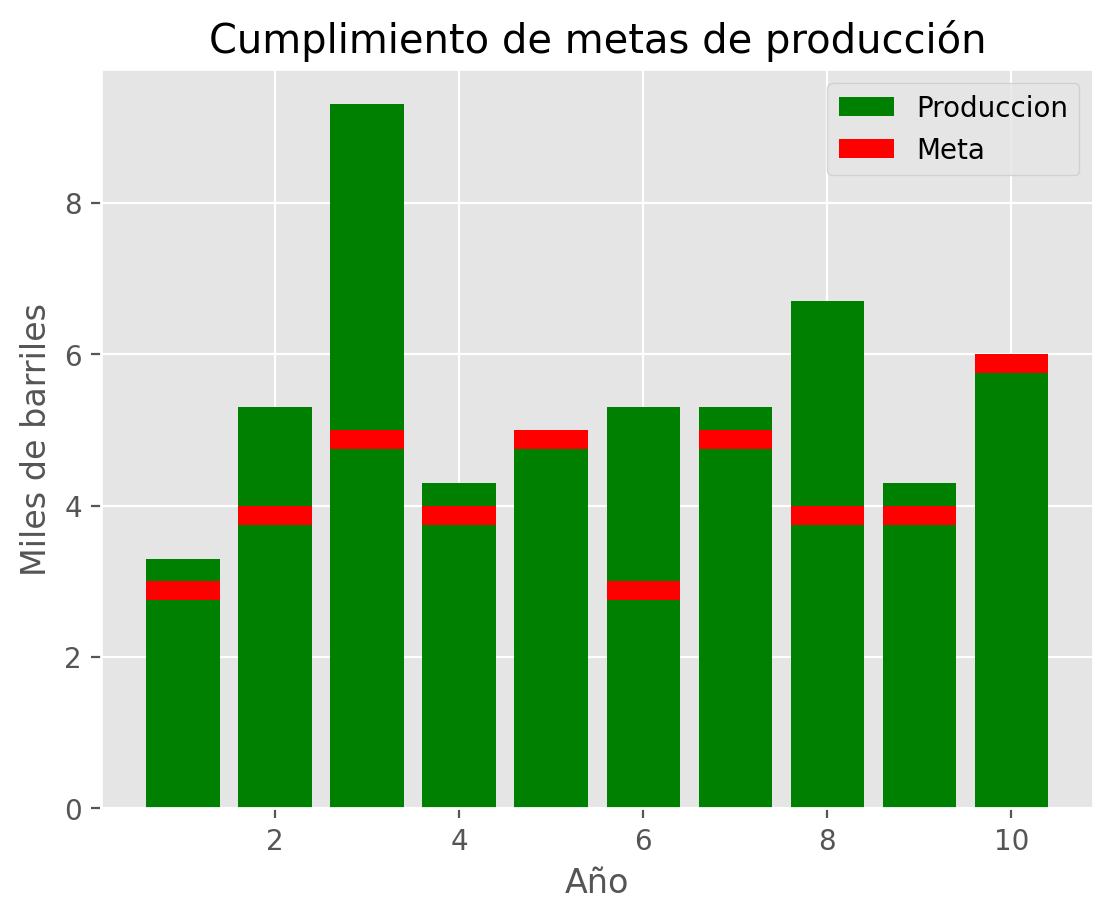

In [67]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'  # Configurando resolución de las gráficas
plt.style.use('ggplot')  # Configurando estilo de las gráficas

pr = {t: round(sum((prodProm[i]*lp.value(x[i,t]) for i in Pozos)),1) for t in Tiempos}

plt.bar(Tiempos, pr.values(), color='green', label='Produccion')
plt.bar(Tiempos, metas.values(), color='red', label='Meta')
plt.bar(Tiempos, [val-0.25 for val in metas.values()], color='green')

plt.legend()
plt.xlabel('Año')
plt.ylabel('Miles de barriles')
plt.title('Cumplimiento de metas de producción')

plt.show()

### Uso de operarios

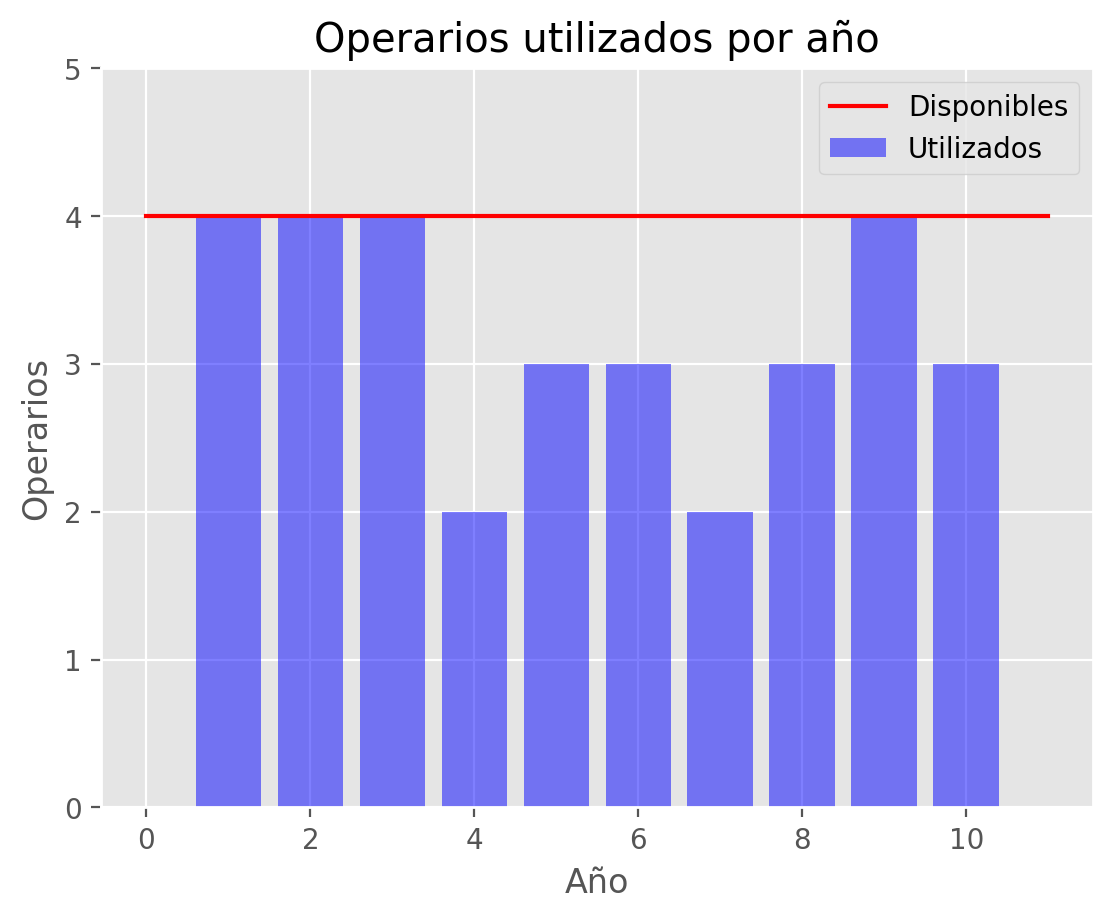

In [68]:
op = {t: sum(operarios[i]*lp.value(x[i,t]) for i in Pozos) for t in Tiempos}

plt.bar(Tiempos, op.values(), color='blue', alpha=0.5, label='Utilizados')
plt.plot(range(0,12), [maxOperarios]*(len(Tiempos)+2), color='red', label='Disponibles')

plt.legend()
plt.ylim(0,5)
plt.xlabel('Año')
plt.ylabel('Operarios')
plt.title('Operarios utilizados por año')

plt.show()

### Uso de generadores

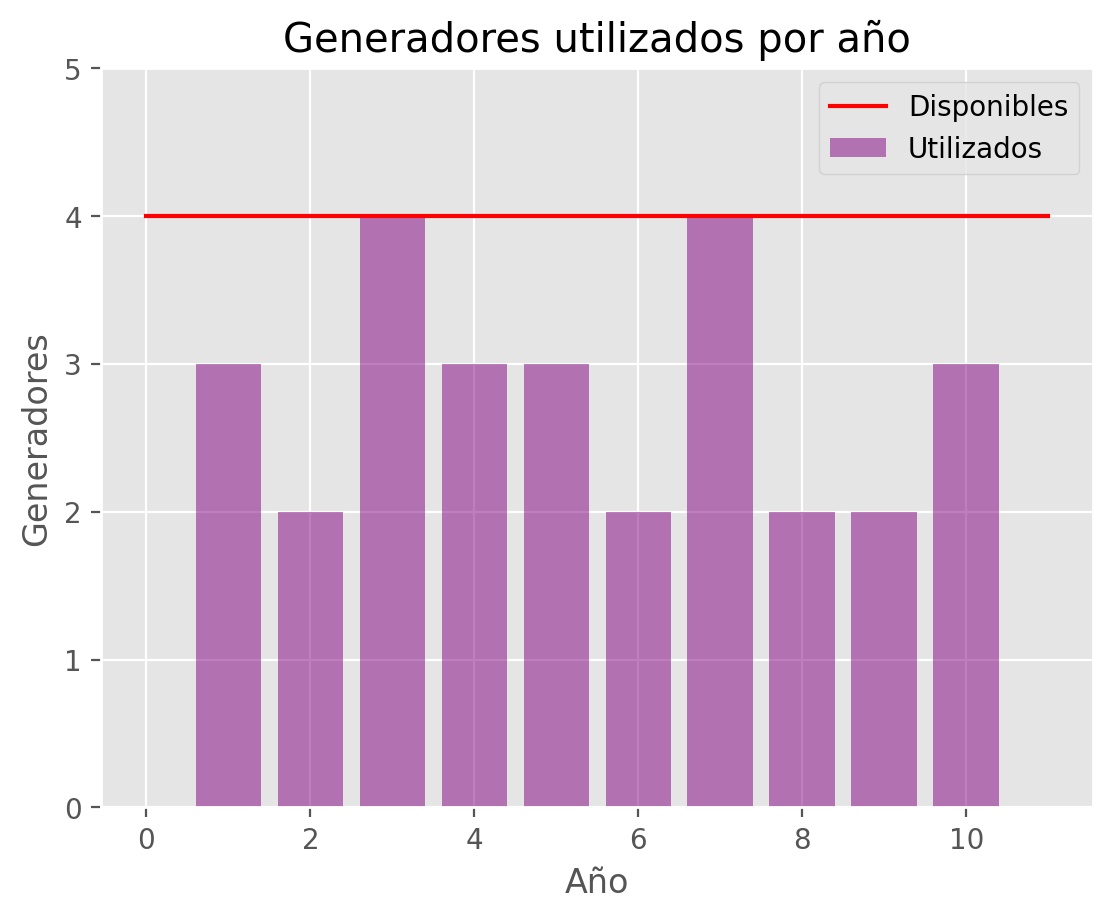

In [ ]:
plt.bar(Tiempos, gen.values(), color='purple', alpha=0.5, label='Utilizados')
plt.plot(range(0,12), [maxGeneradores]*(len(Tiempos)+2), color='red', label='Disponibles')

plt.legend()
plt.ylim(0,5)
plt.xlabel('Año')
plt.ylabel('Generadores')
plt.title('Generadores utilizados por año')

plt.show()

## Opcional (0 puntos)

*Una vez esté listo el modelo, puedes cambiar los valores de los parámetros de la próxima celda para verificar como cambian las soluciones y la función objetivo. Para esto debes correr nuevamente las celdas que crean el modelo desde el principio*

In [ ]:
# Parametros modificables

# Presupuesto máximo
presupuesto = 100

# Máximo número de proyectos a realizar - restricción ambiental
maxProyectos = 12  

# Máximo número de operarios por año
maxOperarios = 4   

# Máximo número de generadores por año
maxGeneradores = 4 

### Fin del laboratorio
---
Cuando hayas finalizado las preguntas, debes presionar el botón "Enviar tarea" en la parte superior.

Después de enviar el laboratorio, debes esperar algunos minutos para que se cargue la nota en Coursera.
¡Muchos éxitos!